# Post-Training Quantization of OpenAI CLIP model with NNCF

The goal of this tutorial is to demonstrate how to use the [NNCF](https://github.com/openvinotoolkit/nncf/) (Neural Network Compression Framework) 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize a OpenVINO model for the high-speed inference via OpenVINO™ Toolkit. The optimization process contains the following steps:

1. Quantize the converted OpenVINO model from [notebook](228-clip-zero-shot-image-classification.ipynb) with NNCF.
2. Check the model result using the same input data from the [notebook](228-clip-zero-shot-image-classification.ipynb).
3. Compare model size of converted and quantized models.
4. Compare performance of converted and quantized models.

> **NOTE**: you should run [228-clip-zero-shot-image-classification.ipynb](228-clip-zero-shot-image-classification.ipynb) notebook first to generate OpenVINO IR models that are used for quantization.

## Prerequisites

In [1]:
!pip install -q datasets

## Create and initialize quantization

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding the quantization layers into the model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires a few modifications.

The optimization process contains the following steps:
1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting a quantized model.
3. Serialize the `INT8` model using `openvino.runtime.serialize` function.

### Prepare datasets

The [LAION-400M](https://laion.ai/blog/laion-400-open-dataset/) dataset contains CLIP-filtered 400 million image-text pairs is used to quantize image and text models.

In [6]:
import requests

from io import BytesIO
from PIL import Image
from transformers import CLIPProcessor
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

def check_text_data(data):
    if isinstance(data, str):
        return True
    if isinstance(data, list):
        return all(isinstance(x, str) for x in data)
    return False

def get_pil_from_url(url):
    response = requests.get(url, verify=False, timeout=20)
    image = Image.open(BytesIO(response.content))
    return image.convert("RGB")

def laion_preprocess(example, image_column="url", text_column="caption"):
    if not check_text_data(example[text_column]):
        raise ValueError("Text data is not valid")

    url = example[image_column]
    try:
        image = get_pil_from_url(url)
    except Exception:
        return None

    # load preprocessor for model input
    inputs = processor(text=example[text_column], images=[image], return_tensors="pt", padding=True)
    return inputs

def collate_fn(examples):
    inputs = [laion_preprocess(example) for example in examples]
    assert len(inputs) == 1
    return inputs[0]

In [7]:
import torch
import itertools
from datasets import load_dataset
from tqdm.notebook import tqdm

def prepare_calibration_data(dataloader, init_steps):
    data = []
    print(f"Fetching {init_steps} for the initialization...")
    counter = 0
    for _, batch in tqdm(zip(range(init_steps), itertools.islice(dataloader, 0, init_steps))):
        if counter == init_steps:
            break
        if batch:
            counter += 1
            with torch.no_grad():
                data.append(
                    {
                        "pixel_values": batch["pixel_values"].to("cpu"),
                        "input_ids": batch["input_ids"].to("cpu"),
                        "attention_mask": batch["attention_mask"].to("cpu")
                    }
                )
    return data


def prepare_dataset(opt_init_steps=300, max_train_samples=1000):
    dataset = load_dataset("laion/laion400m", streaming=True)
    train_dataset = dataset["train"].shuffle(seed=42, buffer_size=max_train_samples)
    dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, num_workers=2)
    calibration_data = prepare_calibration_data(dataloader, opt_init_steps)
    return calibration_data

Create a quantized model from the pre-trained `FP16` model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take a long time.

In [35]:
import logging
import nncf
from openvino.runtime import Core, serialize

nncf.set_log_level(logging.ERROR)

fp16_model_path = 'clip-vit-base-patch16.xml'
int8_model_path = 'clip-vit-base-patch16_int8.xml'

calibration_data = prepare_dataset()
ov_model = Core().read_model(fp16_model_path)

In [36]:
calibration_dataset = nncf.Dataset(calibration_data)
quantized_model = nncf.quantize(
    model=ov_model,
    calibration_dataset=calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
    ignored_scope=nncf.IgnoredScope(types=['ReduceSum']),
    advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alpha=-1) # disable SmoothQuantization
)
serialize(quantized_model, int8_model_path)

Applying Fast Bias correction: 100%|██████████| 144/144 [00:43<00:00,  3.27it/s]


NNCF also supports quantization-aware training, and other algorithms than quantization.
See the [NNCF documentation](https://github.com/openvinotoolkit/nncf/#documentation) in the NNCF repository for more information.

## Run quantized OpenVINO model

The steps for making predictions with the quantized OpenVINO CLIP model are similar to the PyTorch model. Let us check the model result using the same input data from the [1st notebook](228-clip-zero-shot-image-classification.ipynb).

In [33]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def visualize_result(image:Image, labels:List[str], probs:np.ndarray, top:int = 5):
    """ 
    Utility function for visualization classification results
    params:
      image: input image
      labels: list of classification labels
      probs: model predicted softmaxed probabilities for each label
      top: number of the highest probability results for visualization
    returns:
      None
    """
    plt.figure(figsize=(64, 64))
    top_labels = np.argsort(-probs)[:min(top, probs.shape[0])]
    top_probs = probs[top_labels]
    plt.subplot(8, 8, 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(8, 8, 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in top_labels])
    plt.xlabel("probability")   

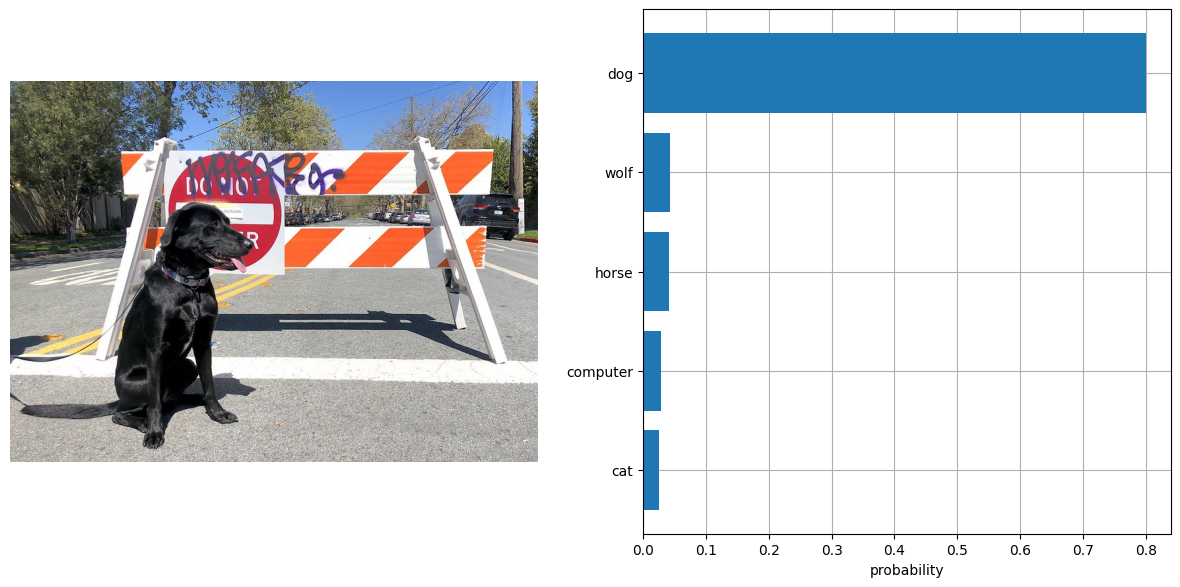

In [38]:
import numpy as np
from scipy.special import softmax
from openvino.runtime import compile_model

image = Image.open('../data/image/coco.jpg')
input_labels = ['cat', 'dog', 'wolf', 'tiger', 'man', 'horse', 'frog', 'tree', 'house', 'computer']
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=[image], return_tensors="pt", padding=True)
compiled_model = compile_model(int8_model_path)
logits_per_image_out = compiled_model.output(0)
ov_logits_per_image = compiled_model(dict(inputs))[logits_per_image_out]
probs = softmax(ov_logits_per_image, axis=1)
visualize_result(image, input_labels, probs[0])

#### Compare File Size

In [40]:
from pathlib import Path

fp16_ir_model_size = Path(fp16_model_path).with_suffix(".bin").stat().st_size / 1024
quantized_model_size = Path(int8_model_path).with_suffix(".bin").stat().st_size / 1024
print(f"FP16 IR model size: {fp16_ir_model_size:.2f} KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 IR model size: 292228.96 KB
INT8 model size: 171753.13 KB
Model compression rate: 1.701


#### Compare inference time of the FP16 IR and quantized models
To measure the inference performance of the `FP16` and `INT8` models, we use median inference time on calibration dataset.
So we can approximately estimate the speed up of the dynamic quantized models.


> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications with static shapes.

In [41]:
import time
from openvino.runtime import compile_model

def calculate_inference_time(model_path, calibration_data):
    model = compile_model(model_path)
    output_layer = model.output(0)
    inference_time = []
    for batch in calibration_data:
        start = time.perf_counter()
        _ = model(batch)[output_layer]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [43]:
fp16_latency = calculate_inference_time(fp16_model_path, calibration_data)
int8_latency = calculate_inference_time(int8_model_path, calibration_data)
print(f"Performance speed up: {fp16_latency / int8_latency:.3f}")

Performance speed up: 1.395
